# Traffic sign detection with YOLO V2

In [3]:
import glob
import csv
import cv2
import os
import random
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import init
from mxnet import gpu
from mxnet import autograd
from mxnet import gluon
from mxnet import nd
from mxnet.gluon import nn
from mxnet.gluon import Block, HybridBlock
from mxnet.gluon.model_zoo import vision

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load Data

In [4]:
NUM_CLASS = 43
BATCH_SIZE = 4
DATA_SHAPE = 512

train_data = mx.image.ImageIter(
   batch_size=BATCH_SIZE, label_width = 1,
   data_shape=(3, DATA_SHAPE, DATA_SHAPE), 
   path_imgrec='./dataset/dataset.rec',  
   path_imgidx='./dataset/dataset.idx',  #help shuffle performance
   shuffle=True)

batch = train_data.next()

def get_label():
    paths = glob.glob("dataset/scene-jpg/*.jpg")
    labels = nd.zeros((len(paths), NUM_CLASS+1, 5)) -1.
    print(labels.shape)
    gts = open("dataset/gt1.txt",'r').read().split('\n')[:-1]
    for gt in gts:
        line = gt.split(";")
        idx = int(line[0].split(".")[0])
        minx = float(line[1])
        miny = float(line[2])
        maxx = float(line[3])
        maxy = float(line[4])
        label = float(line[5])
        labels[idx][int(label)] = [label, minx, miny, maxx, maxy]
    return labels

def get_signname():
    signname_file = "dataset/signnames.csv"
    with open(signname_file) as f:
        f.readline() # skip the headers
        signnames = [row[1] for row in csv.reader(f)]
    return signnames

labels = get_label()
signnames = get_signname()
        
for label in labels[1]:
    if(label[0] >= 0):
        print(label)

(900, 44, 5)

[13.      0.7154  0.4188  0.7581  0.4875]
<NDArray 5 @cpu(0)>

[38.      0.2838  0.6175  0.325   0.69  ]
<NDArray 5 @cpu(0)>

[40.      0.7228  0.485   0.7529  0.54  ]
<NDArray 5 @cpu(0)>


[217 329 881 197]
217
1 Speed limit (30km/h) 365 170 388 209
329
881
5 Speed limit (80km/h) 179 349 193 371
197
11 Right-of-way at the next intersection 326 177 359 231


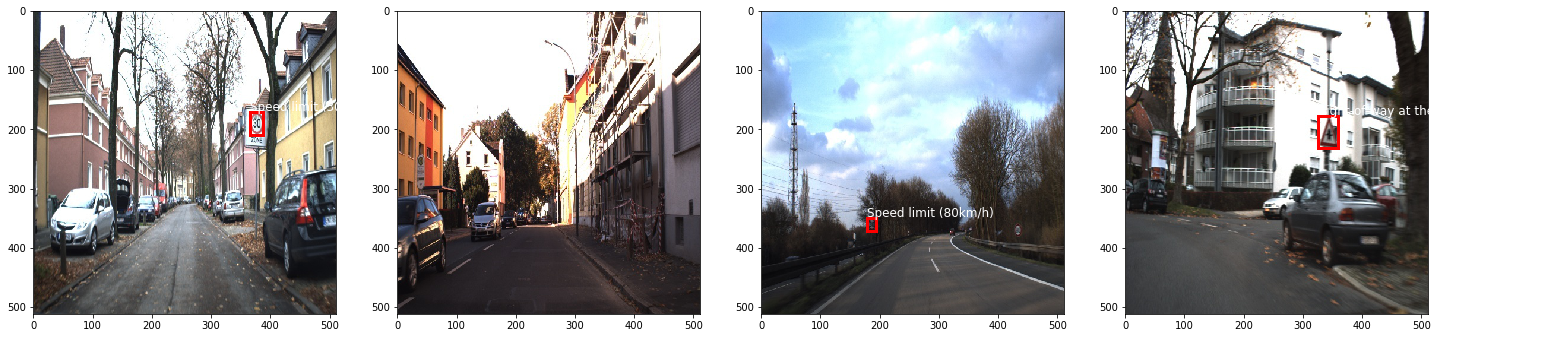

In [5]:
%matplotlib inline
batch_label = batch.label[0].asnumpy().astype(int)
print(batch_label)

fig,ax = plt.subplots(1, 4, figsize=(25,25))
for i in range(4):
    print(batch_label[i])
    img = batch.data[0][i]
    img = img.transpose((1, 2, 0))
    img = img.clip(0,255).asnumpy() / 255
    mul_label = labels[batch_label][i].asnumpy()
    ax[i].imshow(img)
    for box in mul_label:
        sign = int(box[0])
        if(sign < 0):
            continue
        minx = int(box[1] * DATA_SHAPE)
        miny = int(box[2] * DATA_SHAPE)
        maxx = int(box[3] * DATA_SHAPE)
        maxy = int(box[4] * DATA_SHAPE)
        print(sign, signnames[sign], minx, miny, maxx, maxy)
        rect = plt.Rectangle((minx, miny), maxx-minx, maxy-miny,fill=False, edgecolor='red', linewidth=3)
        ax[i].add_patch(rect)
        ax[i].text(minx, miny-2, '{:s}'.format(signnames[sign]),fontsize=12, color='white')
plt.show()

# YOLO V2

In [6]:
def transform_center(xy):
    """Given x, y prediction after sigmoid(), convert to relative coordinates (0, 1) on image."""
    b, h, w, n, s = xy.shape
    offset_y = nd.tile(nd.arange(0, h, repeat=(w * n * 1), ctx=xy.context).reshape((1, h, w, n, 1)), (b, 1, 1, 1, 1))
    # print(offset_y[0].asnumpy()[:, :, 0, 0])
    offset_x = nd.tile(nd.arange(0, w, repeat=(n * 1), ctx=xy.context).reshape((1, 1, w, n, 1)), (b, h, 1, 1, 1))
    # print(offset_x[0].asnumpy()[:, :, 0, 0])
    x, y = xy.split(num_outputs=2, axis=-1)
    x = (x + offset_x) / w
    y = (y + offset_y) / h
    return x, y

def transform_size(wh, anchors):
    """Given w, h prediction after exp() and anchor sizes, convert to relative width/height (0, 1) on image"""
    b, h, w, n, s = wh.shape
    aw, ah = nd.tile(nd.array(anchors, ctx=wh.context).reshape((1, 1, 1, -1, 2)), (b, h, w, 1, 1)).split(num_outputs=2, axis=-1)
    w_pred, h_pred = nd.exp(wh).split(num_outputs=2, axis=-1)
    w_out = w_pred * aw / w
    h_out = h_pred * ah / h
    return w_out, h_out

def yolo2_forward(x, num_class, anchor_scales):
    """Transpose/reshape/organize convolution outputs."""
    stride = num_class + 5
    # transpose and reshape, 4th dim is the number of anchors
    x = x.transpose((0, 2, 3, 1))
    x = x.reshape((0, 0, 0, -1, stride))
    # now x is (batch, m, n, stride), stride = num_class + 1(object score) + 4(coordinates)
    # class probs
    cls_pred = x.slice_axis(begin=0, end=num_class, axis=-1)
    # object score
    score_pred = x.slice_axis(begin=num_class, end=num_class + 1, axis=-1)
    score = nd.sigmoid(score_pred)
    # center prediction, in range(0, 1) for each grid
    xy_pred = x.slice_axis(begin=num_class + 1, end=num_class + 3, axis=-1)
    xy = nd.sigmoid(xy_pred)
    # width/height prediction
    wh = x.slice_axis(begin=num_class + 3, end=num_class + 5, axis=-1)
    # convert x, y to positions relative to image
    x, y = transform_center(xy)
    # convert w, h to width/height relative to image
    w, h = transform_size(wh, anchor_scales)
    # cid is the argmax channel
    cid = nd.argmax(cls_pred, axis=-1, keepdims=True)
    # convert to corner format boxes
    half_w = w / 2
    half_h = h / 2
    left = nd.clip(x - half_w, 0, 1)
    top = nd.clip(y - half_h, 0, 1)
    right = nd.clip(x + half_w, 0, 1)
    bottom = nd.clip(y + half_h, 0, 1)
    output = nd.concat(*[cid, score, left, top, right, bottom], dim=4)
    return output, cls_pred, score, nd.concat(*[xy, wh], dim=4)

In [7]:
def corner2center(boxes, concat=True):
    """Convert left/top/right/bottom style boxes into x/y/w/h format"""
    left, top, right, bottom = boxes.split(axis=-1, num_outputs=4)
    x = (left + right) / 2
    y = (top + bottom) / 2
    width = right - left
    height = bottom - top
    if concat:
        last_dim = len(x.shape) - 1
        return nd.concat(*[x, y, width, height], dim=last_dim)
    return x, y, width, height

def center2corner(boxes, concat=True):
    """Convert x/y/w/h style boxes into left/top/right/bottom format"""
    x, y, w, h = boxes.split(axis=-1, num_outputs=4)
    w2 = w / 2
    h2 = h / 2
    left = x - w2
    top = y - h2
    right = x + w2
    bottom = y + h2
    if concat:
        last_dim = len(left.shape) - 1
        return nd.concat(*[left, top, right, bottom], dim=last_dim)
    return left, top, right, bottom

def yolo2_target(scores, boxes, labels, anchors, ignore_label=-1, thresh=0.5):
    """Generate training targets given predictions and labels."""
    b, h, w, n, _ = scores.shape
    anchors = np.reshape(np.array(anchors), (-1, 2))
    #scores = nd.slice_axis(outputs, begin=1, end=2, axis=-1)
    #boxes = nd.slice_axis(outputs, begin=2, end=6, axis=-1)
    gt_boxes = nd.slice_axis(labels, begin=1, end=5, axis=-1)
    target_score = nd.zeros((b, h, w, n, 1), ctx=scores.context)
    target_id = nd.ones_like(target_score, ctx=scores.context) * ignore_label
    target_box = nd.zeros((b, h, w, n, 4), ctx=scores.context)
    sample_weight = nd.zeros((b, h, w, n, 1), ctx=scores.context)
    for b in range(len(labels)):
        # find the best match for each ground-truth
        label = labels[b].asnumpy()
        valid_label = label[np.where(label[:, 0] > -0.5)[0], :]
        # shuffle because multi gt could possibly match to one anchor, we keep the last match randomly
        np.random.shuffle(valid_label)
        for l in valid_label:
            gx, gy, gw, gh = (l[1] + l[3]) / 2, (l[2] + l[4]) / 2, l[3] - l[1], l[4] - l[2]
            ind_x = int(gx * w)
            ind_y = int(gy * h)
            tx = gx * w - ind_x
            ty = gy * h - ind_y
            gw = gw * w
            gh = gh * h
            # find the best match using width and height only, assuming centers are identical
            intersect = np.minimum(anchors[:, 0], gw) * np.minimum(anchors[:, 1], gh)
            ovps = intersect / (gw * gh + anchors[:, 0] * anchors[:, 1] - intersect)
            best_match = int(np.argmax(ovps))
            target_id[b, ind_y, ind_x, best_match, :] = l[0]
            target_score[b, ind_y, ind_x, best_match, :] = 1.0
            tw = np.log(gw / anchors[best_match, 0])
            th = np.log(gh / anchors[best_match, 1])
            target_box[b, ind_y, ind_x, best_match, :] = mx.nd.array([tx, ty, tw, th])
            sample_weight[b, ind_y, ind_x, best_match, :] = 1.0
            # print('ind_y', ind_y, 'ind_x', ind_x, 'best_match', best_match, 't', tx, ty, tw, th, 'ovp', ovps[best_match], 'gt', gx, gy, gw/w, gh/h, 'anchor', anchors[best_match, 0], anchors[best_match, 1])
    return target_id, target_score, target_box, sample_weight

In [8]:
class YOLO2Output(HybridBlock):
    def __init__(self, num_class, anchor_scales, **kwargs):
        super(YOLO2Output, self).__init__(**kwargs)
        assert num_class > 0, "number of classes should > 0, given {}".format(num_class)
        self._num_class = num_class
        assert isinstance(anchor_scales, (list, tuple)), "list or tuple of anchor scales required"
        assert len(anchor_scales) > 0, "at least one anchor scale required"
        for anchor in anchor_scales:
            assert len(anchor) == 2, "expected each anchor scale to be (width, height), provided {}".format(anchor)
        self._anchor_scales = anchor_scales
        out_channels = len(anchor_scales) * (num_class + 1 + 4)
        with self.name_scope():
            self.output = nn.Conv2D(out_channels, 1, 1)

    def hybrid_forward(self, F, x, *args):
        return self.output(x)

# Train

In [9]:
from mxnet import metric

class LossRecorder(mx.metric.EvalMetric):
    """LossRecorder is used to record raw loss so we can observe loss directly
    """
    def __init__(self, name):
        super(LossRecorder, self).__init__(name)

    def update(self, labels, preds=0):
        """Update metric with pure loss
        """
        for loss in labels:
            if isinstance(loss, mx.nd.NDArray):
                loss = loss.asnumpy()
            self.sum_metric += loss.sum()
            self.num_inst += 1

obj_loss = LossRecorder('objectness_loss')
cls_loss = LossRecorder('classification_loss')
box_loss = LossRecorder('box_refine_loss')

sce_loss = gluon.loss.SoftmaxCrossEntropyLoss(from_logits=False)
l1_loss = gluon.loss.L1Loss()

positive_weight = 5.0
negative_weight = 0.1
class_weight = 1.0
box_weight = 5.0

In [83]:
def get_net(archor_scales):
    pretrained = vision.get_model('resnet18_v1', pretrained=True, root='/home/lsq/Carnd1/my/Traffic-Sign-Detection').features
    net = nn.HybridSequential()
    for i in range(len(pretrained) - 2):
        net.add(pretrained[i])

    # use 44 classes, 1 as dummy class, otherwise softmax won't work
    predictor = YOLO2Output(NUM_CLASS, archor_scales)
    predictor.initialize()
    net.add(predictor)
    return net

START_EPOCH = 300
END_EPOCH = 400
# anchor scales, try adjust it yourself
scales = [[3.3004, 3.59034],[9.84923, 8.23783]]
net = get_net(scales)
ctx = gpu(0)
net.load_params('params/yolo2_%d.params'%START_EPOCH)
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': 7e-4, 'wd': 5e-4})

In [84]:
%%time
import time

def train():
    for epoch in range(START_EPOCH, END_EPOCH):
        # reset data iterators and metrics
        train_data.reset()
        cls_loss.reset()
        obj_loss.reset()
        box_loss.reset()
        tic = time.time()
        for i, batch in enumerate(train_data):
            x = batch.data[0].as_in_context(ctx)
            batch_label = batch.label[0].asnumpy().astype(int)
            y = labels[batch_label].as_in_context(ctx)
            with autograd.record():
                x = net(x)
                output, cls_pred, score, xywh = yolo2_forward(x, NUM_CLASS, scales)
                with autograd.pause():
                    tid, tscore, tbox, sample_weight = yolo2_target(score, xywh, y, scales, thresh=0.5)
                # losses
                loss1 = sce_loss(cls_pred, tid, sample_weight * class_weight)
                score_weight = nd.where(sample_weight > 0,
                                        nd.ones_like(sample_weight) * positive_weight,
                                        nd.ones_like(sample_weight) * negative_weight)
                loss2 = l1_loss(score, tscore, score_weight)
                loss3 = l1_loss(xywh, tbox, sample_weight * box_weight)
                loss = loss1 + loss2 + loss3
            loss.backward()
            trainer.step(BATCH_SIZE)
            # update metrics
            cls_loss.update(loss1)
            obj_loss.update(loss2)
            box_loss.update(loss3)

        print('Epoch %2d, train %s %.5f, %s %.5f, %s %.5f time %.1f sec' % (
            epoch, *cls_loss.get(), *obj_loss.get(), *box_loss.get(), time.time()-tic))

    net.save_params('params/yolo2_%d.params' % END_EPOCH)
    
train()

Epoch 300, train classification_loss 0.00024, objectness_loss 0.00018, box_refine_loss 0.00014 time 49.4 sec
Epoch 301, train classification_loss 0.00024, objectness_loss 0.00018, box_refine_loss 0.00014 time 49.1 sec
Epoch 302, train classification_loss 0.00023, objectness_loss 0.00018, box_refine_loss 0.00014 time 49.5 sec
Epoch 303, train classification_loss 0.00024, objectness_loss 0.00018, box_refine_loss 0.00014 time 50.0 sec
Epoch 304, train classification_loss 0.00024, objectness_loss 0.00018, box_refine_loss 0.00014 time 49.6 sec
Epoch 305, train classification_loss 0.00024, objectness_loss 0.00018, box_refine_loss 0.00015 time 49.7 sec
Epoch 306, train classification_loss 0.00024, objectness_loss 0.00018, box_refine_loss 0.00014 time 49.6 sec
Epoch 307, train classification_loss 0.00024, objectness_loss 0.00018, box_refine_loss 0.00014 time 49.2 sec
Epoch 308, train classification_loss 0.00024, objectness_loss 0.00018, box_refine_loss 0.00014 time 49.1 sec
Epoch 309, train cl

Epoch 376, train classification_loss 0.00024, objectness_loss 0.00019, box_refine_loss 0.00014 time 48.6 sec
Epoch 377, train classification_loss 0.00025, objectness_loss 0.00019, box_refine_loss 0.00014 time 48.5 sec
Epoch 378, train classification_loss 0.00025, objectness_loss 0.00019, box_refine_loss 0.00014 time 48.5 sec
Epoch 379, train classification_loss 0.00024, objectness_loss 0.00019, box_refine_loss 0.00013 time 48.4 sec
Epoch 380, train classification_loss 0.00025, objectness_loss 0.00019, box_refine_loss 0.00014 time 48.4 sec
Epoch 381, train classification_loss 0.00025, objectness_loss 0.00019, box_refine_loss 0.00014 time 48.5 sec
Epoch 382, train classification_loss 0.00025, objectness_loss 0.00019, box_refine_loss 0.00014 time 48.4 sec
Epoch 383, train classification_loss 0.00024, objectness_loss 0.00019, box_refine_loss 0.00014 time 48.6 sec
Epoch 384, train classification_loss 0.00025, objectness_loss 0.00019, box_refine_loss 0.00014 time 48.6 sec
Epoch 385, train cl

# Test

In [12]:
def get_test_gt():
    labels = [[] for i in range(50)]
    width = 1360
    height = 800
    gts = open("dataset/512_test_gt.txt",'r').read().split('\n')[:-1]
    for gt in gts:
        line = gt.split(";")
        idx = int(line[0].split(".")[0])
        x1 = float(line[1]) / width
        y1 = float(line[2]) / height
        x2 = float(line[3]) / width
        y2 = float(line[4]) / height
        label = int(line[5])
        labels[idx].append([label, x1, y1, x2, y2])
    return labels

def cal_cate_gt(gt_list):
    cate_gt = [0 for i in range(NUM_CLASS)]
    for gt in gt_list:
        for label in gt:
            cate_gt[label[0]] += 1
    return cate_gt

test_gt = get_test_gt()
cate_gt = cal_cate_gt(test_gt)

In [61]:
def preprocess(image):
    """Takes an image and apply preprocess"""
    # swap BGR to RGB
    image = image[:, :, (2, 1, 0)]
    # convert to float before subtracting mean
    image = image.astype(np.float32)
    # subtract mean
    image -= 128.
    # organize as [batch-channel-height-width]
    image = np.transpose(image, (2, 0, 1))
    image = image[np.newaxis, :]
    # convert to ndarray
    image = nd.array(image)
    return image

def load_net():
    pretrained = vision.get_model('resnet18_v1', pretrained=True, ctx=gpu(0), root='/home/lsq/Carnd1/my/Traffic-Sign-Detection').features
    net = nn.HybridSequential()
    for i in range(len(pretrained) - 2):
        net.add(pretrained[i])

    predictor = YOLO2Output(NUM_CLASS, scales)
    predictor.initialize(ctx=gpu(0))
    net.add(predictor)
    net.load_params('params/yolo2_300.params')
    return net

def predict(net, x):
    x = net(x)
    output, cls_prob, score, xywh = yolo2_forward(x, NUM_CLASS, scales)
    return nd.contrib.box_nms(output.reshape((0, -1, 6)))


[1.        0.9999933 0.7213768 0.4531616 0.7617309 0.5268627]
<NDArray 6 @gpu(0)>

[1.     0.7199 0.455  0.7603 0.5225]
<NDArray 5 @cpu(0)>


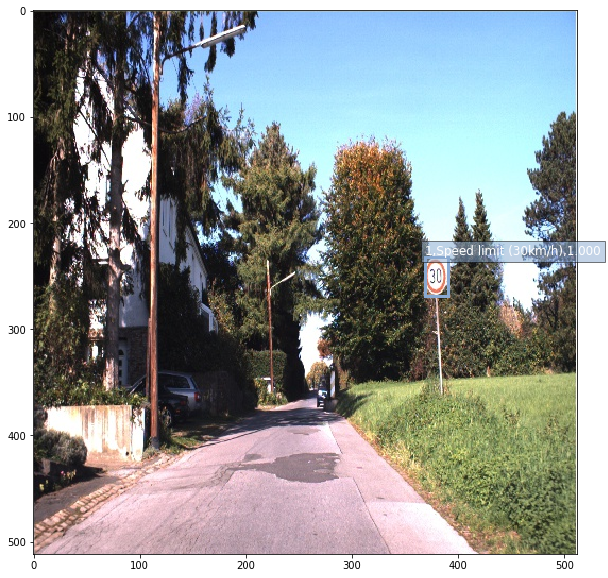

In [79]:
def display(img, out, thresh=0.5):
    mpl.rcParams['figure.figsize'] = (10,10)
    pens = dict()
    plt.clf()
    plt.imshow(img)
    for det in out:
        cid = int(det[0])
        if cid < 0:
            continue
        score = det[1]
        if score < thresh:
            continue
        if cid not in pens:
            pens[cid] = (random.random(), random.random(), random.random())
        scales = [img.shape[1], img.shape[0]] * 2
        xmin, ymin, xmax, ymax = [int(p * s) for p, s in zip(det[2:6].clip(0,1).tolist(), scales)]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, 
                             edgecolor=pens[cid], linewidth=3)
        plt.gca().add_patch(rect)
        text = signnames[cid]
        plt.gca().text(xmin, ymin-2, '{:d},{:s},{:.3f}'.format(cid, text, score),
                       bbox=dict(facecolor=pens[cid], alpha=0.5),
                       fontsize=12, color='white')
    plt.show()

index = random.randint(0, len(test_gt))
image = cv2.imread('dataset/512-test/'+ str(index).zfill(5) +'.jpg')
x = preprocess(image)
# print(x)
net = load_net()
out = predict(net, x.as_in_context(ctx))

for pred in out[0]:
    if pred[1] > 0.5:
        print(pred)
    
for label in labels[index]:
    if(label[0] >= 0):
        print(label)
display(image[:, :, (2, 1, 0)], out[0].asnumpy(), thresh=0.5)

# Ealuate

In [35]:
def get_predict(out_list, thresh=0.5):
    predict_list = []
    for out in out_list:
        if(out[1] > thresh):
            predict_list.append(out)
    return predict_list

def get_label(label_list):
    labels = []
    for label in label_list:
        if(label[0] >= 0):
            labels.append(label)
    return labels

def cal_iou(pre_list, gt_list):
    iou_list = []
    for pre in pre_list:
        for gt in gt_list:
            pic = np.zeros((DATA_SHAPE, DATA_SHAPE), dtype=np.uint16)
            p_x1 = int(pre[2] * (DATA_SHAPE-1))
            p_y1 = int(pre[3] * (DATA_SHAPE-1))
            p_x2 = int(pre[4] * (DATA_SHAPE-1))
            p_y2 = int(pre[5] * (DATA_SHAPE-1))
            pic[p_x1:p_x2, p_y1:p_y2] += 1

            g_x1 = int(gt[1] * (DATA_SHAPE-1))
            g_y1 = int(gt[2] * (DATA_SHAPE-1))
            g_x2 = int(gt[3] * (DATA_SHAPE-1))
            g_y2 = int(gt[4] * (DATA_SHAPE-1))
            pic[g_x1:g_x2, g_y1:g_y2] += 1
            
            u_area = pic[pic==1].size
            i_area = pic[pic==2].size
            iou = i_area / (u_area + i_area + 1e-10)
            if iou > 0.5:
                iou_list.append([gt[0], pre[0], iou])
    return iou_list
    
index = random.randint(0, len(test_gt))
image = cv2.imread('dataset/512-test/'+ str(index).zfill(5) +'.jpg')
x = preprocess(image)
out = predict(net, x.as_in_context(ctx))
pred = get_predict(out[0].asnumpy(), 0.5)
iou = cal_iou(pred, test_gt[index])
print(iou)

[[12, 12.0, 0.7338709677413436]]


In [16]:
def get_predict_list():
    predict_list = np.zeros((50, 2048, 6), dtype=np.float16)
    for i in tqdm(range(50)):
        img = cv2.imread('dataset/512-test/'+ str(i).zfill(5) +'.jpg')
        x = preprocess(img)
        out = predict(net, x.as_in_context(ctx))
        predict_list[i] = out[0].asnumpy()
    return predict_list

def cal_iou_list(pre_list, gt_list):
    iou_list = []
    for i in tqdm(range(50)):
        predict = get_predict(pre_list[i], 0.5)
        gt = gt_list[i]
        iou = cal_iou(predict, gt)
        iou_list.append(iou)
    return iou_list

def cal_pre_rec(iou_list, cate_gt, iou_thresh=0.2):
    cate_predict = np.zeros((NUM_CLASS))
    cate_right = np.zeros((NUM_CLASS))
    
    for iou in iou_list:
        for label in iou:
            pre_label = int(label[1])
            cate_predict[pre_label] += 1
            if(pre_label == label[0] and label[2] > iou_thresh):
                cate_right[pre_label] += 1
    
    cate_pre = cate_right / (cate_predict + 1e-10)
    cate_rec = cate_right / (np.array(cate_gt) + 1e-10)
    
    return cate_pre, cate_rec

In [62]:
def cal_ap(iou_list, cate_gt):
    thresh_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    cate_ap = np.zeros((NUM_CLASS))
    temp_rec = np.zeros((NUM_CLASS))
    for thresh in thresh_list:
        cate_pre, cate_rec = cal_pre_rec(iou_list, cate_gt, 1 - thresh)
        cate_ap += cate_pre * (cate_rec - temp_rec)
        temp_rec = cate_rec
    return cate_ap
    
def cal_map(cate_ap, cate_gt):
    mAP = 0
    N = 0
    for ap, gt in zip(cate_ap, cate_gt):
        if(gt != 0):
            mAP += ap
            N += 1
    return mAP / N
    
predict_list = get_predict_list()
iou_list = cal_iou_list(predict_list, test_gt)
cate_ap = cal_ap(iou_list, cate_gt)
# print(cate_ap)
mAP = cal_map(cate_ap, cate_gt)
print(mAP)

100%|██████████| 50/50 [00:00<00:00, 174.91it/s]

0.5478433401738985
